In [1]:
import pandas as pd
import numpy as np
import data_handler as dh
import model as md
import time
import os
import matplotlib.pyplot as plt
from matplotlib import rc
import pickle

import importlib
importlib.reload(dh)
importlib.reload(md)

In [3]:
import numba
numba.__version__

'0.54.1'

In [4]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)
from platform import python_version
print('python', python_version())
print('numpy', np.__version__)
print('pandas', pd.__version__)
import graph_tool
print('graph_tool', graph_tool.__version__)

/usr/bin/python3
3.9.5 (default, May 24 2021, 12:50:35) 
[GCC 11.1.0]
sys.version_info(major=3, minor=9, micro=5, releaselevel='final', serial=0)
python 3.9.5
numpy 1.20.3
pandas 1.2.5
graph_tool 2.42 (commit 458bd492, Fri Jul 2 22:11:01 2021 +0200)


# Beckmann model

parameter $\mu = 0.25$

## 2. Experiments with perturbation

Let $t^*_{orig}$ be times related to an optimal solution for original transport net, while $t_{FF}$ is free flow times.<br/>
The original network is disturbed - 5\% of the edges are randomly selected and their capacities changes by 30\% with respect to the original capacities:<br/>

$$\widetilde{\overline{f}}_e = \overline{f}_e + \Delta \overline{f}_e, \text{ } \Delta \overline{f}_e  = \pm \, 0.3  \overline{f}_e \cdot \xi, \,\, \xi \sim Be(0.05), \,\, \forall e.$$

Two experiments are carried out with different starting points:
* $t_{start}$ = $t^*_{orig}$
* $t_{start}$ = $t_{FF}$

**Hypothesis**:<br/>
Under the assumption that the network did not change much during the perturbation we believe that 

$$\widetilde{R} = ||\widetilde{t}^* - t^*_{orig}||_2^2 \le ||\widetilde{t}^* - t_{FF}||_2^2 = R_{FF}.$$

Therefore, we expect that the methods starting from the optimum of the original problem will converge faster; moreover, for methods that are most sensitive to the starting point the difference in convergence will be greater.

In [5]:
beckmann_save = 'perturbation_results_final/'
if not os.path.exists(beckmann_save):
    os.mkdir(beckmann_save)

In [6]:
net_name = 'Anaheim_net.tntp'
trips_name = 'Anaheim_trips.tntp'

handler = dh.DataHandler()
answer = handler.ReadAnswer('Anaheim_flow.tntp')
t_start = np.array(answer['times'])

graph_data = handler.GetGraphData(net_name, columns = ['init_node', 'term_node', 'capacity', 'free_flow_time'])
graph_correspondences, total_od_flow = handler.GetGraphCorrespondences(trips_name)
t_free_flow = graph_data['graph_table']['free_flow_time'].values

In [7]:
#perturbation #1
np.random.seed(17)
capacities = graph_data['graph_table']['capacity']
mask = np.random.binomial(n=1, p=0.05, size=capacities.shape)
weights = np.random.choice((-0.3, 0.3), size=capacities.shape)
perturbation = weights * (mask * capacities)

# adjust capacity by 
graph_data['graph_table']['capacity'] = capacities + perturbation

In [8]:
model = md.Model(graph_data, graph_correspondences, 
                    total_od_flow, mu = 0.25, rho = 0.15)

graph_data['graph_table'].head()

,init_node,init_node_thru,term_node,term_node_thru,capacity,free_flow_time
0,1,False,117,True,9000.0,1.090458
1,2,False,87,True,6300.0,1.090458
2,3,False,74,True,9000.0,1.090458
3,4,False,233,True,9000.0,1.090458
4,5,False,165,True,9000.0,1.090458


## Frank-Wolfe method

In [9]:
#new prox oracle etc. t_weighted !!
assert(model.mu == 0.25)
max_iter = 10000

print('Frank-Wolfe without stopping criteria')
solver_kwargs = {'max_iter' : max_iter, 'stop_crit': 'max_iter',
                 'verbose' : True, 'verbose_step': 2000, 'save_history' : True}
tic = time.time()
result = model.find_equilibrium(solver_name = 'fwm', solver_kwargs = solver_kwargs, t_start = t_start)
toc = time.time()
print('Elapsed time: {:.0f} sec'.format(toc - tic))
print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')

with open(beckmann_save + 'anaheim_result_fwm_t_weighted_max_iter_10000_beckmann.pickle', 'wb') as f:
    pickle.dump(result, f)

Frank-Wolfe without stopping criteria
Oracles created...
Frank-Wolfe method...
Given point is used as t_start...
Primal_init = 1.28909e+06
Dual_init = -1.28647e+06
Duality_gap_init = 2629.67

Iterations number: 2000
Primal_func_value = 1.28753e+06
Dual_func_value = -1.28753e+06
Duality_gap = 0.412353
Duality_gap / Duality_gap_init = 0.000156808

Iterations number: 4000
Primal_func_value = 1.28753e+06
Dual_func_value = -1.28753e+06
Duality_gap = 0.204333
Duality_gap / Duality_gap_init = 7.77029e-05

Iterations number: 6000
Primal_func_value = 1.28753e+06
Dual_func_value = -1.28753e+06
Duality_gap = 0.135837
Duality_gap / Duality_gap_init = 5.16554e-05

Iterations number: 8000
Primal_func_value = 1.28753e+06
Dual_func_value = -1.28753e+06
Duality_gap = 0.101619
Duality_gap / Duality_gap_init = 3.86432e-05

Iterations number: 10000
Primal_func_value = 1.28753e+06
Dual_func_value = -1.28753e+06
Duality_gap = 0.0812449
Duality_gap / Duality_gap_init = 3.08954e-05

Result: success
Total iter

## Universal Similar Triangles

In [10]:
epsilons = np.hstack([np.logspace(4, 3, 5)[:-1], np.logspace(3, -0.5, 8)])[::-1]
epsilons

array([3.16227766e-01, 1.00000000e+00, 3.16227766e+00, 1.00000000e+01,
       3.16227766e+01, 1.00000000e+02, 3.16227766e+02, 1.00000000e+03,
       1.77827941e+03, 3.16227766e+03, 5.62341325e+03, 1.00000000e+04])

In [11]:
assert(model.mu == 0.25)
max_iter = 10000
for index, eps_abs in enumerate(epsilons):
    print('eps_abs =', eps_abs)
    solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter, 'stop_crit': 'dual_gap',
                     'verbose' : True, 'verbose_step': 2000, 'save_history' : True}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'ustm', composite = True, solver_kwargs = solver_kwargs,
                                    t_start = t_start)
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
    print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')

    result['eps_abs'] = eps_abs
    result['elapsed_time'] = toc - tic
    with open(beckmann_save + 'anaheim_result_' + 'ustm' + '_eps_abs_' + str(index) + '_beckmann.pickle', 'wb') as f:
        pickle.dump(result, f)

eps_abs = 0.31622776601683794
Composite optimization...
Oracles created...
Universal similar triangles method...
Given point is used as t_start...
Primal_init = 1.28909e+06
Dual_init = -1.28647e+06
Duality_gap_init = 2629.67

Iterations number: 2000
Inner iterations number: 4016
Primal_func_value = 1.28753e+06
Dual_func_value = -1.2869e+06
Duality_gap = 633.133
Duality_gap / Duality_gap_init = 0.240765

Iterations number: 4000
Inner iterations number: 8015
Primal_func_value = 1.28753e+06
Dual_func_value = -1.28709e+06
Duality_gap = 437.796
Duality_gap / Duality_gap_init = 0.166483

Iterations number: 6000
Inner iterations number: 12013
Primal_func_value = 1.28753e+06
Dual_func_value = -1.28722e+06
Duality_gap = 302.065
Duality_gap / Duality_gap_init = 0.114868

Iterations number: 8000
Inner iterations number: 16014
Primal_func_value = 1.28753e+06
Dual_func_value = -1.28732e+06
Duality_gap = 204.561
Duality_gap / Duality_gap_init = 0.0777895

Iterations number: 10000
Inner iterations nu

In [12]:
'''
assert(model.mu == 0.25)
max_iter = 40000
for index, eps_abs in enumerate(epsilons):
    if index < len(epsilons) - 1:
        continue
    print('eps_abs =', eps_abs)
    solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter, 'stop_crit': 'dual_gap',
                     'verbose' : True, 'verbose_step': 4000, 'save_history' : True}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'ustm', composite = True, solver_kwargs = solver_kwargs,
                                    t_start = t_start)
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
    print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')

    result['eps_abs'] = eps_abs
    result['elapsed_time'] = toc - tic
    with open(beckmann_save + 'anaheim_result_' + 'ustm' + '_eps_abs_' + str(index) + '_beckmann.pickle', 'wb') as f:
        pickle.dump(result, f)
'''

"\nassert(model.mu == 0.25)\nmax_iter = 40000\nfor index, eps_abs in enumerate(epsilons):\n    if index < len(epsilons) - 1:\n        continue\n    print('eps_abs =', eps_abs)\n    solver_kwargs = {'eps_abs': eps_abs,\n                     'max_iter': max_iter, 'stop_crit': 'dual_gap',\n                     'verbose' : True, 'verbose_step': 4000, 'save_history' : True}\n    tic = time.time()\n    result = model.find_equilibrium(solver_name = 'ustm', composite = True, solver_kwargs = solver_kwargs,\n                                    t_start = t_start)\n    toc = time.time()\n    print('Elapsed time: {:.0f} sec'.format(toc - tic))\n    print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))\n    print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')\n\n    result['eps_abs'] = eps_abs\n    result['elapsed_time'] = toc - tic\n    with open(beckmann_save + 'anaheim_result_' + 'ustm' + '_eps_abs_' + str

In [13]:
#index += 8
#epsilons = np.logspace(4, 3, 5)[:-1]
#epsilons

## Universal Gradient Descent

In [12]:
epsilons = np.hstack([np.logspace(4, 3, 5)[:-1],np.logspace(3, 1, 7)])[::-1]
epsilons

array([   10.        ,    21.5443469 ,    46.41588834,   100.        ,
         215.443469  ,   464.15888336,  1000.        ,  1778.27941004,
        3162.27766017,  5623.4132519 , 10000.        ])

In [13]:
#weighted t added
assert(model.mu == 0.25)
max_iter = 10000
for index, eps_abs in enumerate(epsilons):
    print('eps_abs =', eps_abs)
    solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter, 'stop_crit': 'dual_gap',
                     'verbose' : True, 'verbose_step': 4000, 'save_history' : True}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'ugd', composite = True, solver_kwargs = solver_kwargs,
                                    t_start = t_start)
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
    print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')
    
    result['eps_abs'] = eps_abs
    result['elapsed_time'] = toc - tic
    with open(beckmann_save + 'anaheim_result_' + 'ugd' + '_eps_abs_' + str(index) + '_beckmann.pickle', 'wb') as f:
        pickle.dump(result, f)

eps_abs = 10.0
Composite optimization...
Oracles created...
Universal gradient descent method...
Given point is used as t_start...
Primal_init = 1.28909e+06
Dual_init = -1.28647e+06
Duality_gap_init = 2629.67

Iterations number: 4000
Inner iterations number: 8001
Primal_func_value = 1.28753e+06
Dual_func_value = -1.28744e+06
Duality_gap = 88.29
Duality_gap / Duality_gap_init = 0.0335745

Iterations number: 8000
Inner iterations number: 16001
Primal_func_value = 1.28753e+06
Dual_func_value = -1.2875e+06
Duality_gap = 26.8946
Duality_gap / Duality_gap_init = 0.0102274

Result: iterations number exceeded
Total iters: 10000
Primal_func_value = 1.28753e+06
Dual_func_value = -1.28751e+06
Duality_gap = 17.6403
Duality_gap / Duality_gap_init = 0.00670817
Oracle elapsed time: 678 sec
Elapsed time: 685 sec
Time ratio = 3.292733488925024
Flow excess = 0.9758581729734677

eps_abs = 21.544346900318846
Composite optimization...
Oracles created...
Universal gradient descent method...
Given point is u

In [16]:
#index += 7
#epsilons = np.logspace(4, 3, 5)[:-1]
#epsilons

## Weighted Dual Averages

### Composite optimization

In [14]:
assert(model.mu == 0.25)
max_iter = 10000#40000
solver_kwargs = {'max_iter' : max_iter, 'stop_crit': 'max_iter',
                 'verbose': True, 'verbose_step': 4000, 'save_history': True}
tic = time.time()
result = model.find_equilibrium(solver_name = 'wda', composite = True, solver_kwargs = solver_kwargs,
                                t_start = t_start)
toc = time.time()
print('Elapsed time: {:.0f} sec'.format(toc - tic))
print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')

result['elapsed_time'] = toc - tic
with open(beckmann_save + 'anaheim_result_' + 'wda' + '_max_iter_' + str(max_iter) + '_beckmann.pickle', 'wb') as f:
    pickle.dump(result, f)

Composite optimization...
Oracles created...
Weighted dual averages method...
Given point is used as t_start...
Primal_init = 1.28909e+06
Dual_init = -1.28647e+06
Duality_gap_init = 2629.67

Iterations number: 4000
Primal_func_value = 1.28753e+06
Dual_func_value = -1.28753e+06
Duality_gap = 1.16015
Duality_gap / Duality_gap_init = 0.000441176

Iterations number: 8000
Primal_func_value = 1.28753e+06
Dual_func_value = -1.28753e+06
Duality_gap = 0.608956
Duality_gap / Duality_gap_init = 0.000231571

Result: success
Total iters: 10000
Primal_func_value = 1.28753e+06
Dual_func_value = -1.28753e+06
Duality_gap = 0.49424
Duality_gap / Duality_gap_init = 0.000187947
Oracle elapsed time: 296 sec
Elapsed time: 300 sec
Time ratio = 3.290285640156722
Flow excess = 0.9766194704178259



## Plots

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
import numpy as np

In [66]:
beckmann_save = 'perturbation_results_final/'
results = {}

for method in ['ustm', 'ugd']:
    results[method] = {}
    results[method]['iters'] = []
    results[method]['inner_iters'] = []
    results[method]['epsilon'] = []
    results[method]['dual_gap_init'] = []
    i = 0
    while True:
        try:
            with open(beckmann_save + 'anaheim_result_' + method + '_eps_abs_'
                      + str(i) + '_beckmann.pickle', 'rb') as f:
                result = pickle.load(f)
                results[method]['epsilon'].append(result['eps_abs'])
                results[method]['iters'].append(result['iter_num'])
                results[method]['inner_iters'].append(result['history'].get('inner_iters')[-1])
                results[method]['dual_gap_init'].append(result['history'].get('dual_gap')[0])
        except FileNotFoundError:
            break
        i += 1

        
for method in ['wda']:
    results[method] = {}
    with open(beckmann_save + 'anaheim_result_' + method + '_max_iter_10000_beckmann.pickle', 'rb') as f:
        result = pickle.load(f)
        results[method]['epsilon'] = result['history'].get('dual_gap')
        results[method]['iters'] = result['history'].get('iter')
        results[method]['dual_gap_init'] = result['history'].get('dual_gap')[0]
        
        
method = 'fwm'
with open(beckmann_save + 'anaheim_result_fwm_t_weighted_max_iter_10000_beckmann.pickle', 'rb') as f:
    results[method] = {}
    result = pickle.load(f)
    results[method]['epsilon'] = result['history'].get('dual_gap')
    results[method]['iters'] = result['history'].get('iter')
    results[method]['dual_gap_init'] = result['history'].get('dual_gap')[0]

In [67]:
beckmann_save = 'perturbation_results_free_flow_final/'
results_ff = {}

for method in ['ustm', 'ugd']:
    results_ff[method] = {}
    results_ff[method]['iters'] = []
    results_ff[method]['inner_iters'] = []
    results_ff[method]['epsilon'] = []
    results_ff[method]['dual_gap_init'] = []
    i = 0
    while True:
        try:
            with open(beckmann_save + 'anaheim_result_' + method + '_eps_abs_'
                      + str(i) + '_beckmann.pickle', 'rb') as f:
                result = pickle.load(f)
                results_ff[method]['epsilon'].append(result['eps_abs'])
                results_ff[method]['iters'].append(result['iter_num'])
                results_ff[method]['inner_iters'].append(result['history'].get('inner_iters')[-1])
                results_ff[method]['dual_gap_init'].append(result['history'].get('dual_gap')[0])
        except FileNotFoundError:
            break
        i += 1

        
for method in ['wda']:
    results_ff[method] = {}
    with open(beckmann_save + 'anaheim_result_' + method + '_max_iter_10000_beckmann.pickle', 'rb') as f:
        result = pickle.load(f)
        results_ff[method]['epsilon'] = result['history'].get('dual_gap')
        results_ff[method]['iters'] = result['history'].get('iter')
        results_ff[method]['dual_gap_init'] = result['history'].get('dual_gap')[0]
        
        
method = 'fwm'
with open(beckmann_save + 'anaheim_result_fwm_t_weighted_max_iter_10000_beckmann.pickle', 'rb') as f:
    results_ff[method] = {}
    result = pickle.load(f)
    results_ff[method]['epsilon'] = result['history'].get('dual_gap')
    results_ff[method]['iters'] = result['history'].get('iter')
    results_ff[method]['dual_gap_init'] = result['history'].get('dual_gap')[0]

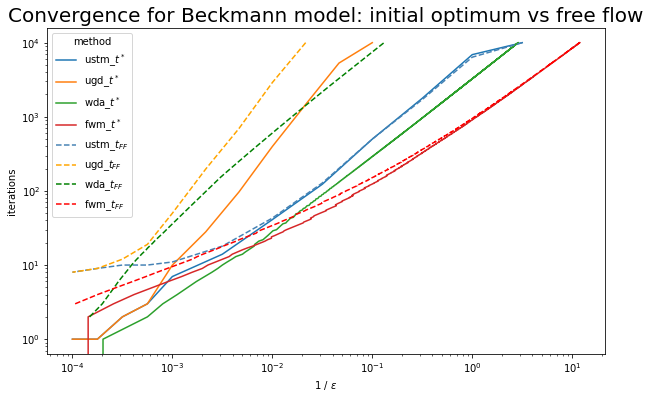

In [89]:
plt.figure(figsize=(10, 6))
plt.title('Convergence for Beckmann model: initial optimum vs free flow', fontsize=20)
eps_upper = 1e4
for method, data in results.items():
    x = 1. / np.array(data['epsilon'])
    y = np.array(data['iters'])
    ind = np.nonzero(1 / x <= eps_upper)
    plt.plot(x[ind], y[ind], label = f'{method}_$t^*$')
    
for (method, data), c in zip(results_ff.items(), ['steelblue', 'orange', 'green', 'red']):
    x = 1. / np.array(data['epsilon'])
    y = np.array(data['iters'])
    ind = np.nonzero(1 / x <= eps_upper)
    if method == 'ugd':
        plt.plot(x[ind][2:], y[ind][2:], '--', c=c, label=f'{method}_'+ r'$t_{FF}$')
    else:
        plt.plot(x[ind], y[ind], '--', c=c, label=f'{method}_'+ r'$t_{FF}$')
    
plt.legend(title = 'method')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'1 / $\varepsilon$')
plt.ylabel('iterations')
plt.show()

As expected there is significant correlation with Natalia's results (experiment_initialization.ipynb). <br/>
Specifically, all methods converge faster in case of $t_{start} = t^*_{orig}$ compared to $t_{start}$ = $t_{FF}$. The difference in the convergence rate is significantly higher for "unstable" to initialization methods of UGD and WDA. While the convergence rate of FWM and USTM is basically the same for both initialization.<br/> 
To sum up, these results are similar with ones obtained in the first experiment.